<a href="https://colab.research.google.com/github/Byeon-MJ/TIL/blob/main/%5BDL%5D_PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch로 CNN 모델 구현하기
* Fashion MNIST 데이터셋 분류

In [6]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

## 변수 설정

In [5]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
EPOCHS = 40
BATCH_SIZE = 64
print(DEVICE)

cuda


## 데이터셋 로드

In [8]:
train_loader = DataLoader(
    datasets.FashionMNIST('./.data',
                          train=True,
                          download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307, ), (0.3081,))
                          ])),
    batch_size=BATCH_SIZE, shuffle=True
)

test_loader = DataLoader(
    datasets.FashionMNIST('./.data',
                          train=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307, ), (0.3081,))
                          ])),
    batch_size=BATCH_SIZE, shuffle=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [9]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)

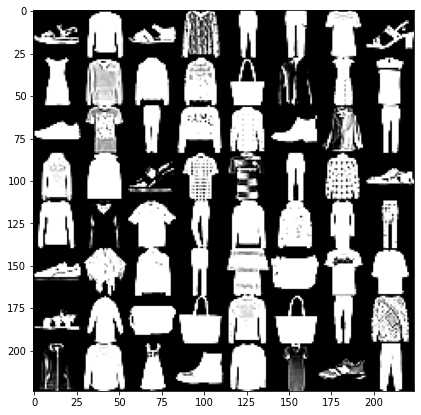

In [10]:
images, labels = next(dataiter)

img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

## 모델링

In [11]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # CNN 첫번째 레이어 : 흑백사진 -> Color Channel이 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        # 20 x 4 x 4 = 320
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

## 모델 생성 & Optimizer

In [13]:
model = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [14]:
from torchsummary import summary
summary(model, (1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 10, 24, 24]             260
            Conv2d-2             [64, 20, 8, 8]           5,020
         Dropout2d-3             [64, 20, 8, 8]               0
            Linear-4                   [64, 50]          16,050
            Linear-5                   [64, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 4.09
Params size (MB): 0.08
Estimated Total Size (MB): 4.37
----------------------------------------------------------------


## 훈련 함수 생성

In [15]:
def train(model, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()     # 오차역전파
        optimizer.step()    # 모델의 학습 파라미터 갱신

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

## 평가 함수 생성

In [16]:
def evaluate(model, test_loader):
    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 예측값 찾기 : 가장 높은 인덱스
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## CNN 모델 학습

In [17]:
for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print(f'[{epoch}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314794
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.320764
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.918623
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.029913
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.991116
[1] Test Loss: 0.7018, Accuracy: 72.46%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.963187
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.736005
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.692928
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.598175
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.616816
[2] Test Loss: 0.6013, Accuracy: 76.62%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.841547
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.911998
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.891789
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.682781
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.697156
[3] Test Loss: 0.5486, Accuracy: 78.32%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.839151
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.500034
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.919934
